# Deep Learning Model Comparison for Multi-Output Regression

This notebook implements and compares 5 different deep learning architectures:
1. **Simple Feed-Forward Network** - Basic dense layers
2. **Deep Network with BatchNorm & Dropout** - Regularized deep architecture
3. **Residual Network (ResNet-style)** - Skip connections for better gradient flow
4. **Multi-Task Learning Network** - Shared representation with task-specific heads
5. **Attention-Enhanced Network** - Self-attention mechanism for feature importance


In [59]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


PyTorch version: 2.7.1
Device: mps


## 1. Data Loading and Preprocessing


In [60]:
# Load Dataset
try:
    df = pd.read_csv('AMLData/train.csv')
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: AMLData/train.csv not found.")

# Display basic info
print(f"\nFeatures: {df.columns.tolist()}")
print(f"\nDataset Statistics:")
df.describe().round(3)


Dataset loaded successfully. Shape: (80000, 17)

Features: ['time', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Y1', 'Y2']

Dataset Statistics:


,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,Y1,Y2
count,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000,80000.000
mean,40003.926,0.069,-0.005,-0.001,0.032,-0.000,0.063,-0.000,-0.003,0.070,-0.000,-0.001,0.019,-0.001,0.001,-0.003,-0.061
std,23095.035,1.078,1.031,1.010,1.047,1.036,1.069,1.036,1.041,1.065,1.015,1.038,1.058,1.013,1.025,0.971,0.924
min,0.000,-0.643,-0.771,-30.068,-0.899,-29.531,-0.738,-35.715,-23.599,-0.762,-34.806,-0.729,-0.735,-29.342,-49.870,-28.918,-0.851
25%,20004.750,-0.374,-0.452,-0.418,-0.501,-0.476,-0.415,-0.420,-0.437,-0.395,-0.432,-0.405,-0.438,-0.386,-0.366,-0.388,-0.498
50%,40004.500,-0.265,-0.285,-0.004,-0.279,-0.007,-0.237,-0.005,0.007,-0.187,0.004,-0.264,-0.292,0.004,0.005,-0.002,-0.318
75%,60004.250,0.005,0.061,0.414,0.167,0.459,0.132,0.422,0.445,0.160,0.437,0.033,0.055,0.387,0.367,0.392,0.027
max,80004.000,24.918,53.667,29.313,28.490,39.322,46.838,22.023,20.635,33.605,19.118,49.279,38.850,27.179,32.488,29.859,34.636


In [61]:
# Data Split: 60k training, 20k testing (matching original notebook)
train_full = df.sample(n=60000, random_state=42)
test_full = df.drop(train_full.index)

# Drop 'time' column if exists
cols_to_drop = ['time']
train_df = train_full.drop(columns=[c for c in cols_to_drop if c in train_full.columns])
test_df = test_full.drop(columns=[c for c in cols_to_drop if c in test_full.columns])

# Prepare features and targets
X_train = train_df.drop(columns=['Y1', 'Y2']).values
y_train = train_df[['Y1', 'Y2']].values

X_test = test_df.drop(columns=['Y1', 'Y2']).values
y_test = test_df[['Y1', 'Y2']].values

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")


Training set: X=(60000, 14), y=(60000, 2)
Test set: X=(20000, 14), y=(20000, 2)


In [62]:
# Feature Scaling (only scale features, NOT targets - matching ML.ipynb approach)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# DO NOT scale targets - keep them in original scale for proper comparison
# This matches the approach in ML.ipynb where only features are scaled

# Create validation split from training data (smaller split to keep more training data)
val_split = 0.1  # Reduced from 0.15 to keep more training data
val_size = int(len(X_train_scaled) * val_split)
indices = np.random.permutation(len(X_train_scaled))

X_val_scaled = X_train_scaled[indices[:val_size]]
y_val = y_train[indices[:val_size]]  # Unscaled targets
X_train_final = X_train_scaled[indices[val_size:]]
y_train_final = y_train[indices[val_size:]]  # Unscaled targets

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_final).to(device)
y_train_tensor = torch.FloatTensor(y_train_final).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoaders
BATCH_SIZE = 512  # Increased batch size for more stable gradients
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Final Training: {X_train_final.shape[0]} samples")
print(f"Validation: {X_val_scaled.shape[0]} samples")
print(f"Test: {X_test_scaled.shape[0]} samples")
print(f"Target Y1 range: [{y_train[:, 0].min():.2f}, {y_train[:, 0].max():.2f}]")
print(f"Target Y2 range: [{y_train[:, 1].min():.2f}, {y_train[:, 1].max():.2f}]")


Final Training: 54000 samples
Validation: 6000 samples
Test: 20000 samples
Target Y1 range: [-28.92, 29.86]
Target Y2 range: [-0.84, 34.64]


## 2. Model Architectures

### Common Training Configuration


In [63]:
# Training configuration
INPUT_DIM = X_train_final.shape[1]
OUTPUT_DIM = 2
EPOCHS = 300  # Increased from 150
LEARNING_RATE = 0.005  # Increased initial learning rate

# Training function for PyTorch models
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE, patience=30, weight_decay=1e-4):
    """Train a PyTorch model with early stopping and learning rate scheduling"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)  # AdamW with weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=15, min_lr=1e-6
    )
    
    history = {'loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping with relative improvement threshold
        if val_loss < best_val_loss * 0.9999:  # Require meaningful improvement
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - LR: {current_lr:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (best val_loss: {best_val_loss:.4f})")
            break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    return model, history

print(f"Input dimensions: {INPUT_DIM}")
print(f"Output dimensions: {OUTPUT_DIM}")


Input dimensions: 14
Output dimensions: 2


### Model 1: Simple Feed-Forward Network

A basic multi-layer perceptron with dense layers.


In [64]:
class SimpleFFN(nn.Module):
    """Simple Feed-Forward Neural Network - Enhanced capacity"""
    def __init__(self, input_dim, output_dim):
        super(SimpleFFN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
        
        # Initialize weights properly
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.network(x)

# Build and display model
model_1 = SimpleFFN(INPUT_DIM, OUTPUT_DIM)
print(model_1)
print(f"\nTotal parameters: {sum(p.numel() for p in model_1.parameters()):,}")


SimpleFFN(
  (network): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)

Total parameters: 47,138


In [65]:
# Train Model 1
print("Training Model 1: Simple Feed-Forward Network...")
model_1, history_1 = train_model(model_1, train_loader, val_loader)
print("Model 1 training complete!")


Training Model 1: Simple Feed-Forward Network...
Epoch 20/300 - Loss: 0.1925 - Val Loss: 0.2137 - LR: 0.005000
Epoch 40/300 - Loss: 0.1634 - Val Loss: 0.2242 - LR: 0.005000
Early stopping at epoch 56 (best val_loss: 0.1982)
Training completed. Best validation loss: 0.1982
Model 1 training complete!


### Model 2: Deep Network with BatchNorm & Dropout

A deeper architecture with regularization techniques to prevent overfitting.


In [66]:
class DeepRegularized(nn.Module):
    """Deep Network with Batch Normalization and Dropout - Enhanced"""
    def __init__(self, input_dim, output_dim):
        super(DeepRegularized, self).__init__()
        
        # Block 1 - Wider
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15)
        )
        
        # Block 4
        self.block4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)
        )
        
        # Output
        self.output_layer = nn.Linear(64, output_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.output_layer(x)

# Build and display model
model_2 = DeepRegularized(INPUT_DIM, OUTPUT_DIM)
print(model_2)
print(f"\nTotal parameters: {sum(p.numel() for p in model_2.parameters()):,}")


DeepRegularized(
  (block1): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (block3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.15, inplace=False)
  )
  (block4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0

In [67]:
# Train Model 2
print("Training Model 2: Deep Network with BatchNorm & Dropout...")
model_2, history_2 = train_model(model_2, train_loader, val_loader)
print("Model 2 training complete!")


Training Model 2: Deep Network with BatchNorm & Dropout...
Epoch 20/300 - Loss: 0.2340 - Val Loss: 0.2027 - LR: 0.005000
Epoch 40/300 - Loss: 0.2118 - Val Loss: 0.1959 - LR: 0.002500
Epoch 60/300 - Loss: 0.1968 - Val Loss: 0.1972 - LR: 0.001250
Epoch 80/300 - Loss: 0.1846 - Val Loss: 0.1974 - LR: 0.000625
Early stopping at epoch 91 (best val_loss: 0.1899)
Training completed. Best validation loss: 0.1899
Model 2 training complete!


### Model 3: Residual Network (ResNet-style)

Network with skip connections to improve gradient flow and enable deeper architectures.


In [68]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection - Enhanced"""
    def __init__(self, in_features, out_features, dropout_rate=0.15):
        super(ResidualBlock, self).__init__()
        
        self.main_path = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        
        # Skip connection - adjust dimensions if needed
        self.skip = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        self.activation = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        residual = self.skip(x)
        out = self.main_path(x)
        out = out + residual
        return self.activation(out)


class ResNetRegressor(nn.Module):
    """Residual Network for Regression - Enhanced"""
    def __init__(self, input_dim, output_dim):
        super(ResNetRegressor, self).__init__()
        
        # Initial projection - Wider
        self.initial = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1)
        )
        
        # Residual blocks - More capacity
        self.res_blocks = nn.Sequential(
            ResidualBlock(256, 256, dropout_rate=0.15),
            ResidualBlock(256, 256, dropout_rate=0.15),
            ResidualBlock(256, 128, dropout_rate=0.1),
            ResidualBlock(128, 128, dropout_rate=0.1),
            ResidualBlock(128, 64, dropout_rate=0.1)
        )
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, output_dim)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        return self.output_layers(x)

# Build and display model
model_3 = ResNetRegressor(INPUT_DIM, OUTPUT_DIM)
print(model_3)
print(f"\nTotal parameters: {sum(p.numel() for p in model_3.parameters()):,}")


ResNetRegressor(
  (initial): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (main_path): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Dropout(p=0.15, inplace=False)
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip): Identity()
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (1): ResidualBlock(
      (main_path): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tr

In [69]:
# Train Model 3
print("Training Model 3: Residual Network...")
model_3, history_3 = train_model(model_3, train_loader, val_loader)
print("Model 3 training complete!")


Training Model 3: Residual Network...
Epoch 20/300 - Loss: 0.2090 - Val Loss: 0.2182 - LR: 0.005000
Epoch 40/300 - Loss: 0.1852 - Val Loss: 0.1958 - LR: 0.005000
Epoch 60/300 - Loss: 0.1401 - Val Loss: 0.2070 - LR: 0.002500
Early stopping at epoch 68 (best val_loss: 0.1952)
Training completed. Best validation loss: 0.1952
Model 3 training complete!


### Model 4: Multi-Task Learning Network

Shared representation learning with task-specific output heads for Y1 and Y2.


In [70]:
class MultiTaskNetwork(nn.Module):
    """Multi-Task Learning Network with shared trunk and task-specific heads - Enhanced"""
    def __init__(self, input_dim):
        super(MultiTaskNetwork, self).__init__()
        
        # Shared trunk (feature extraction) - Wider
        self.shared_trunk = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1)
        )
        
        # Task-specific head for Y1 - More capacity
        self.y1_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )
        
        # Task-specific head for Y2 - More capacity
        self.y2_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        shared = self.shared_trunk(x)
        y1 = self.y1_head(shared)
        y2 = self.y2_head(shared)
        return torch.cat([y1, y2], dim=1)

# Build and display model
model_4 = MultiTaskNetwork(INPUT_DIM)
print(model_4)
print(f"\nTotal parameters: {sum(p.numel() for p in model_4.parameters()):,}")


MultiTaskNetwork(
  (shared_trunk): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.15, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
  )
  (y1_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=32, o

In [71]:
# Train Model 4
print("Training Model 4: Multi-Task Learning Network...")
model_4, history_4 = train_model(model_4, train_loader, val_loader)
print("Model 4 training complete!")


Training Model 4: Multi-Task Learning Network...
Epoch 20/300 - Loss: 0.2218 - Val Loss: 0.2181 - LR: 0.005000
Epoch 40/300 - Loss: 0.1922 - Val Loss: 0.2004 - LR: 0.002500
Epoch 60/300 - Loss: 0.1810 - Val Loss: 0.2091 - LR: 0.001250
Early stopping at epoch 69 (best val_loss: 0.1921)
Training completed. Best validation loss: 0.1921
Model 4 training complete!


### Model 5: Attention-Enhanced Network

Self-attention mechanism to learn feature importance dynamically.


In [72]:
class SelfAttentionBlock(nn.Module):
    """Self-Attention mechanism for tabular data - Enhanced"""
    def __init__(self, in_features, out_features, num_heads=4):
        super(SelfAttentionBlock, self).__init__()
        self.out_features = out_features
        self.num_heads = num_heads
        self.head_dim = out_features // num_heads
        
        self.W_query = nn.Linear(in_features, out_features, bias=False)
        self.W_key = nn.Linear(in_features, out_features, bias=False)
        self.W_value = nn.Linear(in_features, out_features, bias=False)
        self.fc_out = nn.Linear(out_features, out_features)
        
    def forward(self, x):
        batch_size = x.shape[0]
        # x shape: (batch, features)
        
        Q = self.W_query(x)  # (batch, out_features)
        K = self.W_key(x)    
        V = self.W_value(x)  
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, self.num_heads, self.head_dim)
        K = K.view(batch_size, self.num_heads, self.head_dim)
        V = V.view(batch_size, self.num_heads, self.head_dim)
        
        # Scaled dot-product attention
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (self.head_dim ** 0.5)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # Apply attention to values
        attended = torch.bmm(attention_weights, V)
        attended = attended.view(batch_size, self.out_features)
        
        return self.fc_out(attended)


class AttentionNetwork(nn.Module):
    """Attention-Enhanced Network for Regression - Enhanced"""
    def __init__(self, input_dim, output_dim):
        super(AttentionNetwork, self).__init__()
        
        # Initial dense layer - Wider
        self.initial = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1)
        )
        
        # Self-attention block 1
        self.attention1 = SelfAttentionBlock(256, 128, num_heads=4)
        
        # Further processing after first attention
        self.process1 = nn.Sequential(
            nn.Linear(256 + 128, 256),  # Concatenated features
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15)
        )
        
        # Self-attention block 2
        self.attention2 = SelfAttentionBlock(256, 64, num_heads=4)
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(256 + 64, 128),  # Concatenated features
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, output_dim)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Initial processing
        x = self.initial(x)
        
        # First attention block
        attended1 = self.attention1(x)
        x = torch.cat([x, attended1], dim=1)
        
        # Further processing
        x = self.process1(x)
        
        # Second attention block
        attended2 = self.attention2(x)
        x = torch.cat([x, attended2], dim=1)
        
        # Output
        return self.output_layers(x)

# Build and display model
model_5 = AttentionNetwork(INPUT_DIM, OUTPUT_DIM)
print(model_5)
print(f"\nTotal parameters: {sum(p.numel() for p in model_5.parameters()):,}")


AttentionNetwork(
  (initial): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (attention1): SelfAttentionBlock(
    (W_query): Linear(in_features=256, out_features=128, bias=False)
    (W_key): Linear(in_features=256, out_features=128, bias=False)
    (W_value): Linear(in_features=256, out_features=128, bias=False)
    (fc_out): Linear(in_features=128, out_features=128, bias=True)
  )
  (process1): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.15, inplace=False)
  )
  (attention2): SelfAttentionBlock(
    (W_query): Linear(in_features=256, out_features=64, bias=False)
    (W_key): Linear(in_features=256, out_features=64, bias=False)
    (W_value): Linea

In [73]:
# Train Model 5
print("Training Model 5: Attention-Enhanced Network...")
model_5, history_5 = train_model(model_5, train_loader, val_loader)
print("Model 5 training complete!")


Training Model 5: Attention-Enhanced Network...
Epoch 20/300 - Loss: 0.2314 - Val Loss: 0.2025 - LR: 0.005000
Epoch 40/300 - Loss: 0.2163 - Val Loss: 0.2168 - LR: 0.005000
Epoch 60/300 - Loss: 0.2130 - Val Loss: 0.2181 - LR: 0.005000
Epoch 80/300 - Loss: 0.1868 - Val Loss: 0.2368 - LR: 0.002500
Early stopping at epoch 84 (best val_loss: 0.1955)
Training completed. Best validation loss: 0.1955
Model 5 training complete!


## 3. Model Evaluation and Comparison


In [83]:
# Collect all models and histories
models = {
    'Simple FFN': (model_1, history_1),
    'Deep Regularized': (model_2, history_2),
    'ResNet-style': (model_3, history_3),
    'Multi-Task': (model_4, history_4),
    'Attention-Enhanced': (model_5, history_5)
}

# Evaluation function for PyTorch models (no target scaling needed)
def evaluate_model(model, X_test_tensor, y_test_original):
    """Evaluate PyTorch model and return metrics"""
    model.eval()
    with torch.no_grad():
        # Predict directly (targets are not scaled)
        y_pred = model(X_test_tensor).cpu().numpy()
    
    # Calculate metrics
    r2_y1 = r2_score(y_test_original[:, 0], y_pred[:, 0])
    r2_y2 = r2_score(y_test_original[:, 1], y_pred[:, 1])
    
    mse_y1 = mean_squared_error(y_test_original[:, 0], y_pred[:, 0])
    mse_y2 = mean_squared_error(y_test_original[:, 1], y_pred[:, 1])
    
    mae_y1 = mean_absolute_error(y_test_original[:, 0], y_pred[:, 0])
    mae_y2 = mean_absolute_error(y_test_original[:, 1], y_pred[:, 1])
    
    return {
        'R2_Y1': r2_y1,
        'R2_Y2': r2_y2,
        'R2_Avg': (r2_y1 + r2_y2) / 2,
        'MSE_Y1': mse_y1,
        'MSE_Y2': mse_y2,
        'MAE_Y1': mae_y1,
        'MAE_Y2': mae_y2,
        'predictions': y_pred
    }

# Evaluate all models
results = {}
predictions = {}

for name, (model, history) in models.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, X_test_tensor, y_test)
    results[name] = metrics
    predictions[name] = metrics['predictions']
    print(f"  R2 Y1: {metrics['R2_Y1']:.4f}, R2 Y2: {metrics['R2_Y2']:.4f}, Avg: {metrics['R2_Avg']:.4f}")

print("\nEvaluation complete!")


Evaluating Simple FFN...
  R2 Y1: 0.7477, R2 Y2: 0.6717, Avg: 0.7097
Evaluating Deep Regularized...
  R2 Y1: 0.7539, R2 Y2: 0.7023, Avg: 0.7281
Evaluating ResNet-style...
  R2 Y1: 0.7587, R2 Y2: 0.6989, Avg: 0.7288
Evaluating Multi-Task...
  R2 Y1: 0.7462, R2 Y2: 0.6984, Avg: 0.7223
Evaluating Attention-Enhanced...
  R2 Y1: 0.7282, R2 Y2: 0.6790, Avg: 0.7036

Evaluation complete!


In [75]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame([
    {
        'Model': name,
        'R² Y1': metrics['R2_Y1'],
        'R² Y2': metrics['R2_Y2'],
        'R² Average': metrics['R2_Avg'],
        'MSE Y1': metrics['MSE_Y1'],
        'MSE Y2': metrics['MSE_Y2'],
        'MAE Y1': metrics['MAE_Y1'],
        'MAE Y2': metrics['MAE_Y2']
    }
    for name, metrics in results.items()
]).sort_values('R² Average', ascending=False)

print("="*80)
print("DEEP LEARNING MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


DEEP LEARNING MODEL COMPARISON RESULTS
             Model    R² Y1    R² Y2  R² Average   MSE Y1   MSE Y2   MAE Y1   MAE Y2
      ResNet-style 0.758698 0.698868    0.728783 0.225654 0.263444 0.287048 0.251855
  Deep Regularized 0.753902 0.702333    0.728118 0.230139 0.260412 0.285498 0.253169
        Multi-Task 0.746178 0.698406    0.722292 0.237362 0.263848 0.288363 0.257851
        Simple FFN 0.747672 0.671667    0.709670 0.235965 0.287241 0.291062 0.260391
Attention-Enhanced 0.728196 0.678953    0.703575 0.254178 0.280866 0.293664 0.263790


## 4. Visualization


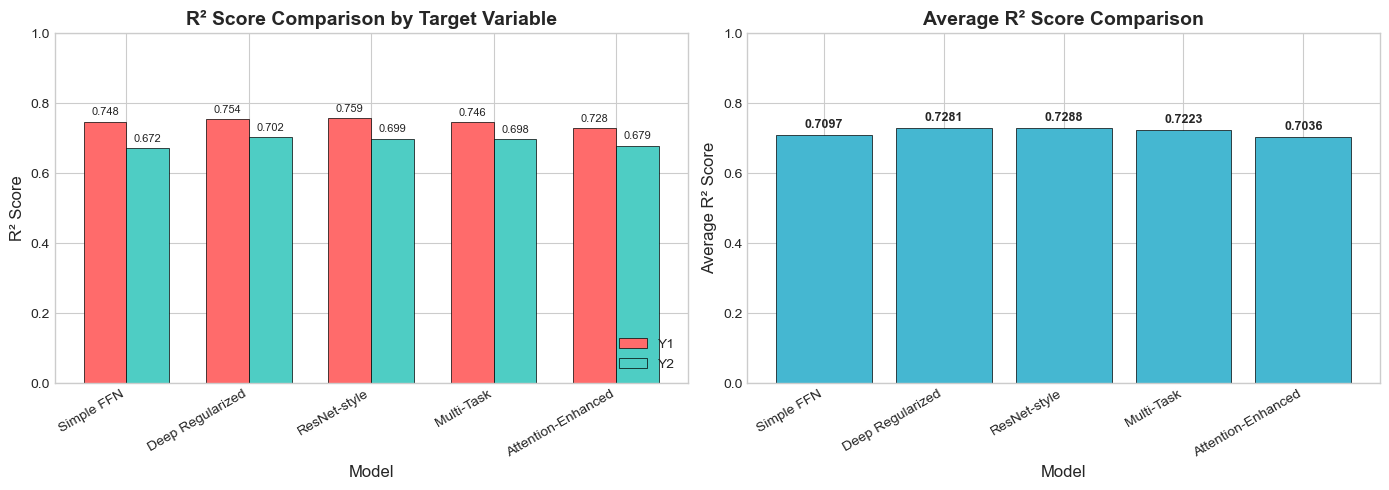

In [84]:
# Set style for beautiful plots
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# 1. R² Score Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(results.keys())
r2_y1 = [results[m]['R2_Y1'] for m in model_names]
r2_y2 = [results[m]['R2_Y2'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

# R² Scores
bars1 = axes[0].bar(x - width/2, r2_y1, width, label='Y1', color=colors[0], edgecolor='black', linewidth=0.5)
bars2 = axes[0].bar(x + width/2, r2_y2, width, label='Y2', color=colors[1], edgecolor='black', linewidth=0.5)

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison by Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=30, ha='right', fontsize=10)
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1])

# Add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Average R² Score
r2_avg = [results[m]['R2_Avg'] for m in model_names]
bars_avg = axes[1].bar(x, r2_avg, color=colors[2], edgecolor='black', linewidth=0.5)

axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Average R² Score', fontsize=12)
axes[1].set_title('Average R² Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=30, ha='right', fontsize=10)
axes[1].set_ylim([0, 1])

for bar in bars_avg:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_r2.png', dpi=150, bbox_inches='tight')
plt.show()


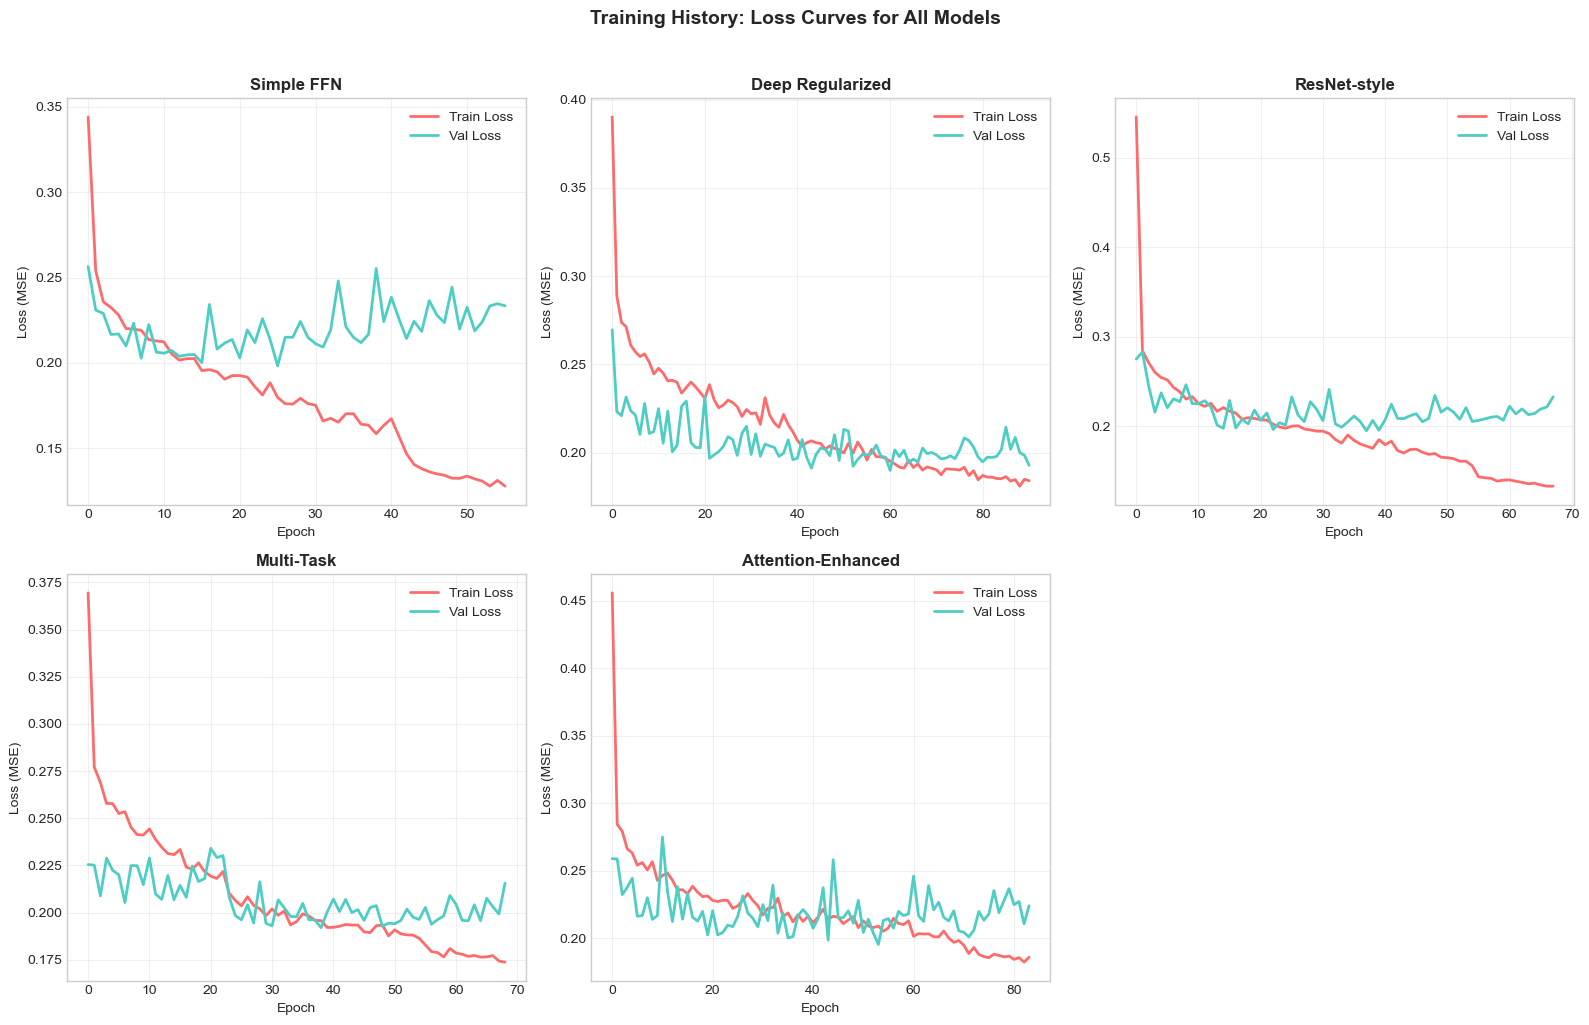

In [77]:
# 2. Training History Comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, (name, (model, history)) in enumerate(models.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Plot training and validation loss (PyTorch history format)
    ax.plot(history['loss'], label='Train Loss', color=colors[0], linewidth=2)
    ax.plot(history['val_loss'], label='Val Loss', color=colors[1], linewidth=2)
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[1, 2].axis('off')

plt.suptitle('Training History: Loss Curves for All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('training_histories.png', dpi=150, bbox_inches='tight')
plt.show()


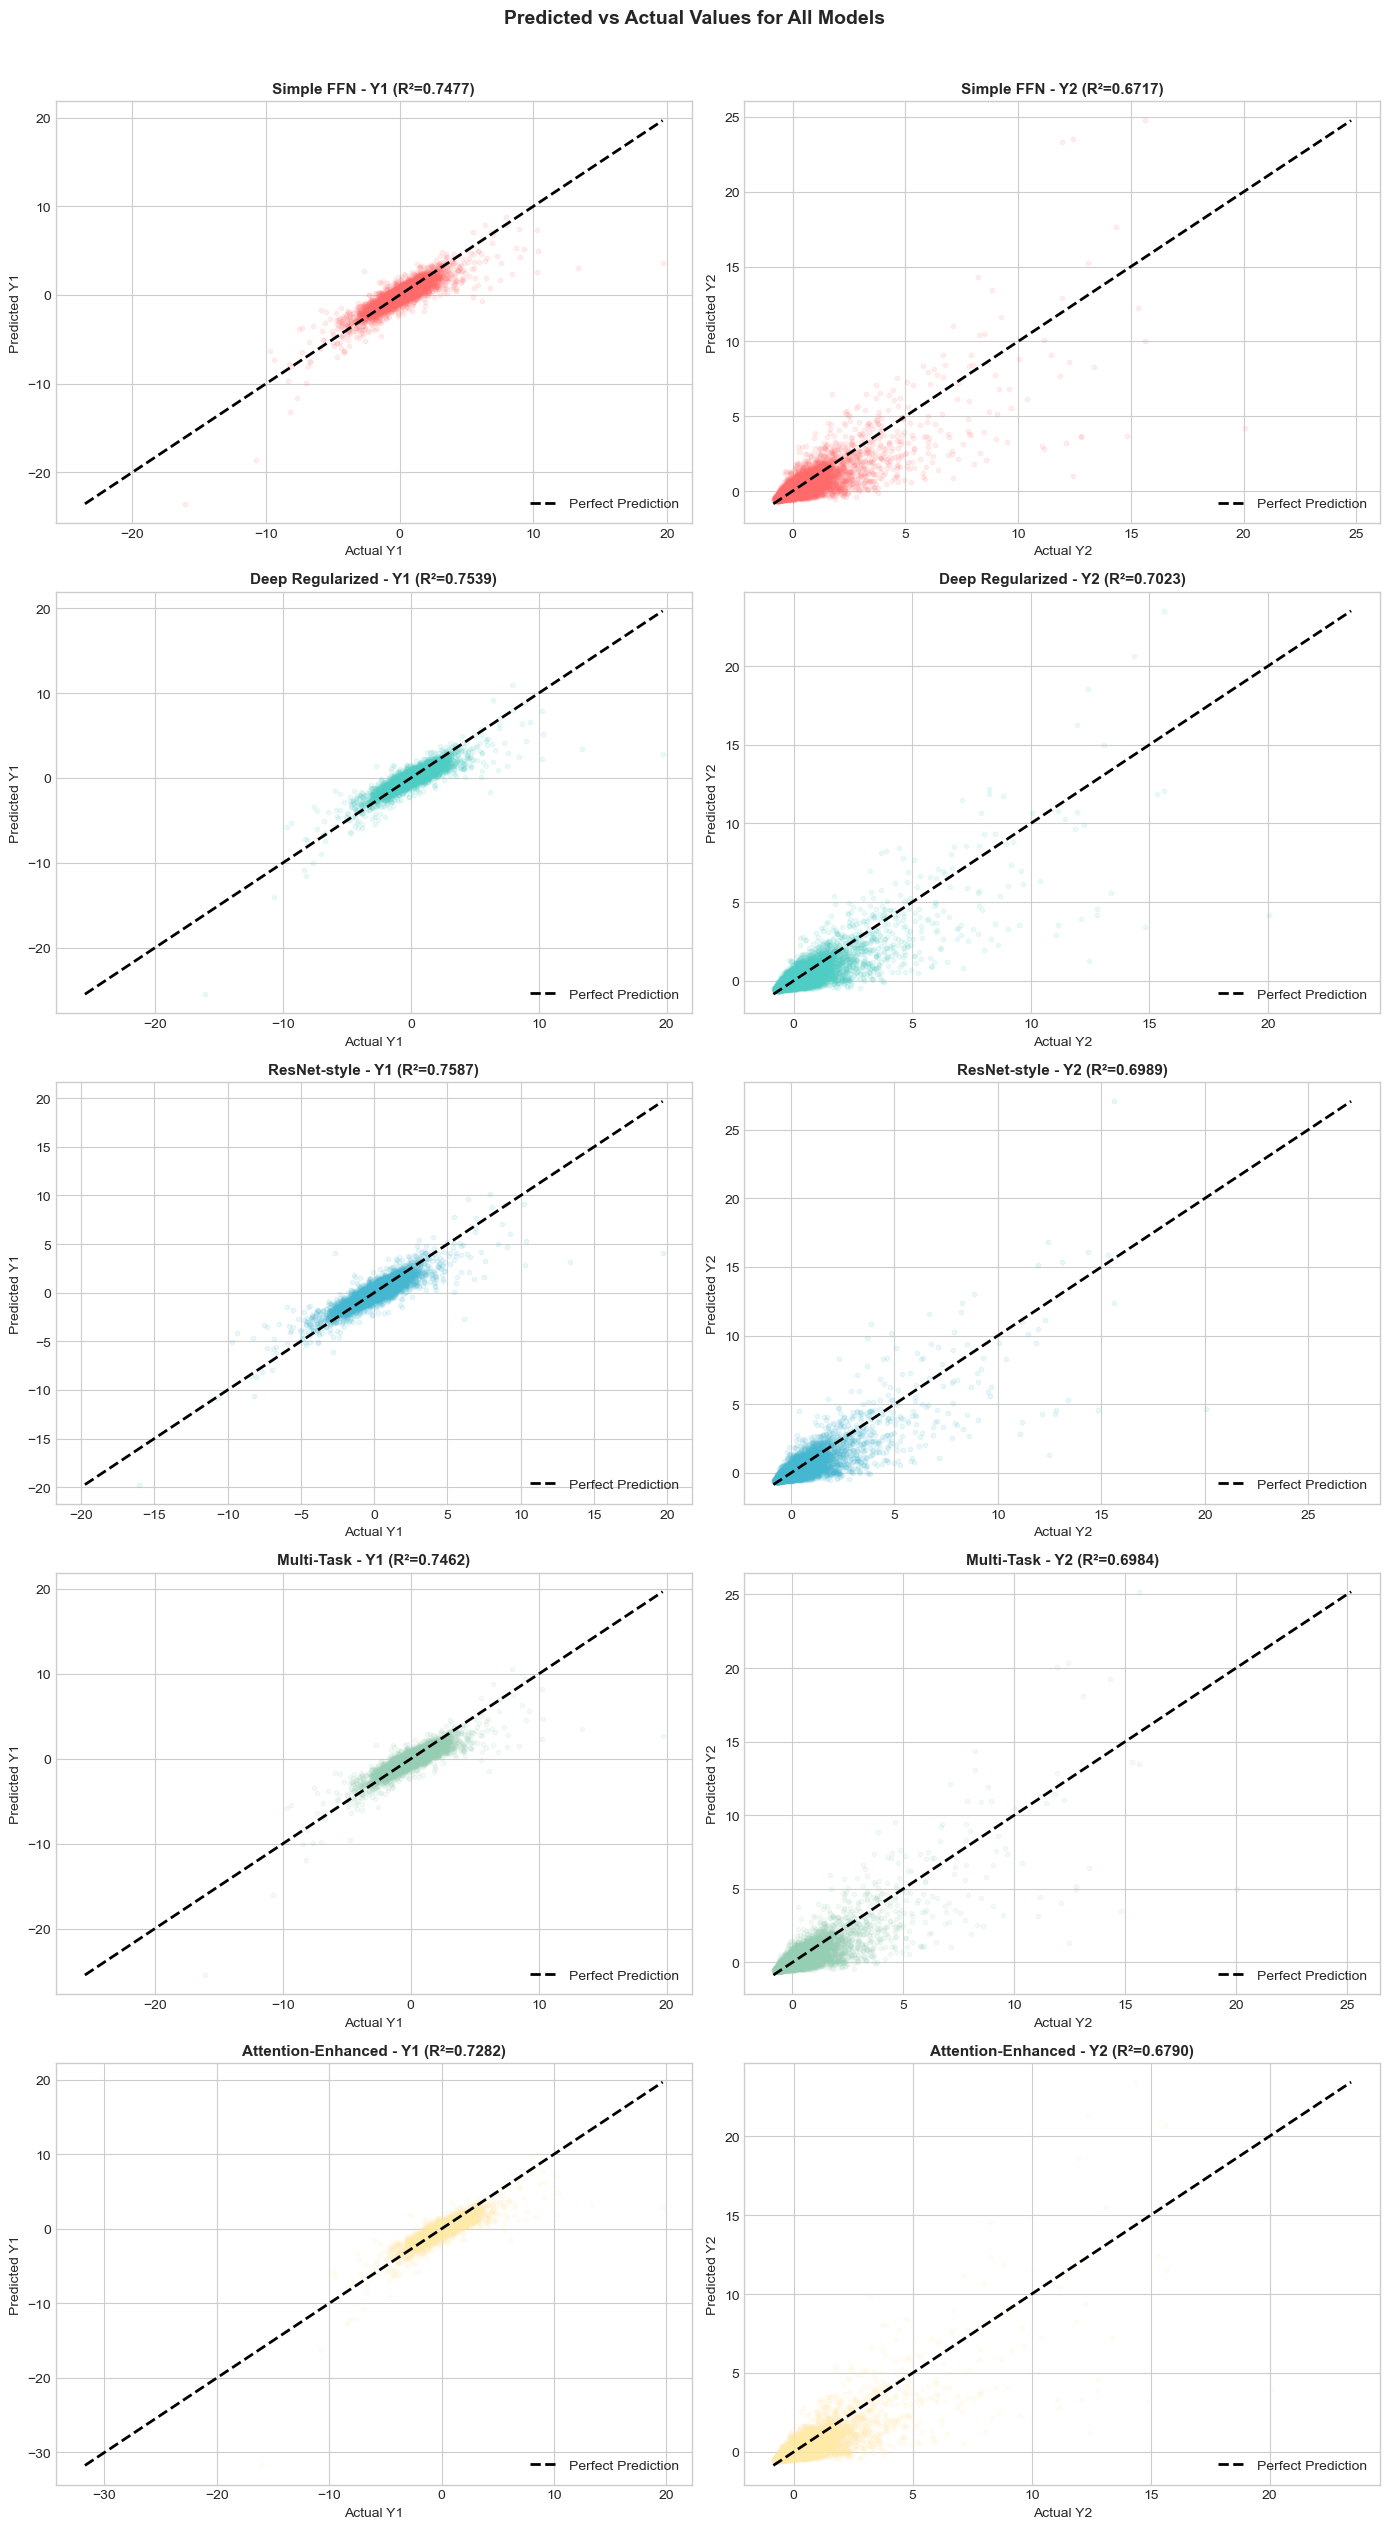

In [85]:
# 3. Predicted vs Actual Scatter Plots
fig, axes = plt.subplots(5, 2, figsize=(14, 25))

for idx, (name, preds) in enumerate(predictions.items()):
    # Y1 Plot
    ax1 = axes[idx, 0]
    ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1, s=10, c=colors[idx % len(colors)])
    
    # Perfect prediction line
    min_val = min(y_test[:, 0].min(), preds[:, 0].min())
    max_val = max(y_test[:, 0].max(), preds[:, 0].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    ax1.set_xlabel('Actual Y1', fontsize=10)
    ax1.set_ylabel('Predicted Y1', fontsize=10)
    ax1.set_title(f'{name} - Y1 (R²={results[name]["R2_Y1"]:.4f})', fontsize=11, fontweight='bold')
    ax1.legend(loc='lower right')
    
    # Y2 Plot
    ax2 = axes[idx, 1]
    ax2.scatter(y_test[:, 1], preds[:, 1], alpha=0.1, s=10, c=colors[idx % len(colors)])
    
    min_val = min(y_test[:, 1].min(), preds[:, 1].min())
    max_val = max(y_test[:, 1].max(), preds[:, 1].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    ax2.set_xlabel('Actual Y2', fontsize=10)
    ax2.set_ylabel('Predicted Y2', fontsize=10)
    ax2.set_title(f'{name} - Y2 (R²={results[name]["R2_Y2"]:.4f})', fontsize=11, fontweight='bold')
    ax2.legend(loc='lower right')

plt.suptitle('Predicted vs Actual Values for All Models', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()


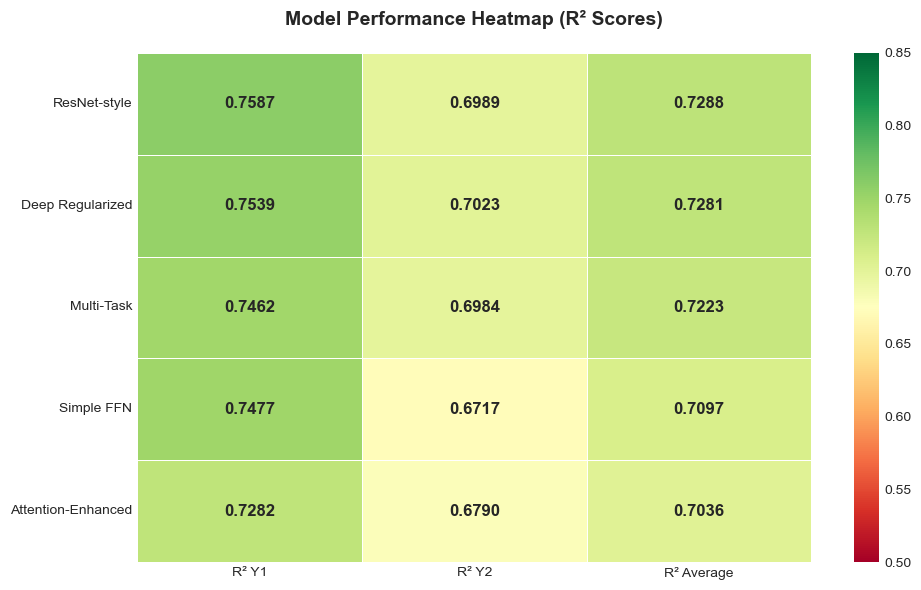

In [86]:
# 4. Comprehensive Metrics Heatmap
metrics_for_heatmap = results_df.set_index('Model')[['R² Y1', 'R² Y2', 'R² Average']].sort_values('R² Average', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.4f', cmap='RdYlGn', 
            linewidths=0.5, ax=ax, vmin=0.5, vmax=0.85,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})

ax.set_title('Model Performance Heatmap (R² Scores)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('performance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


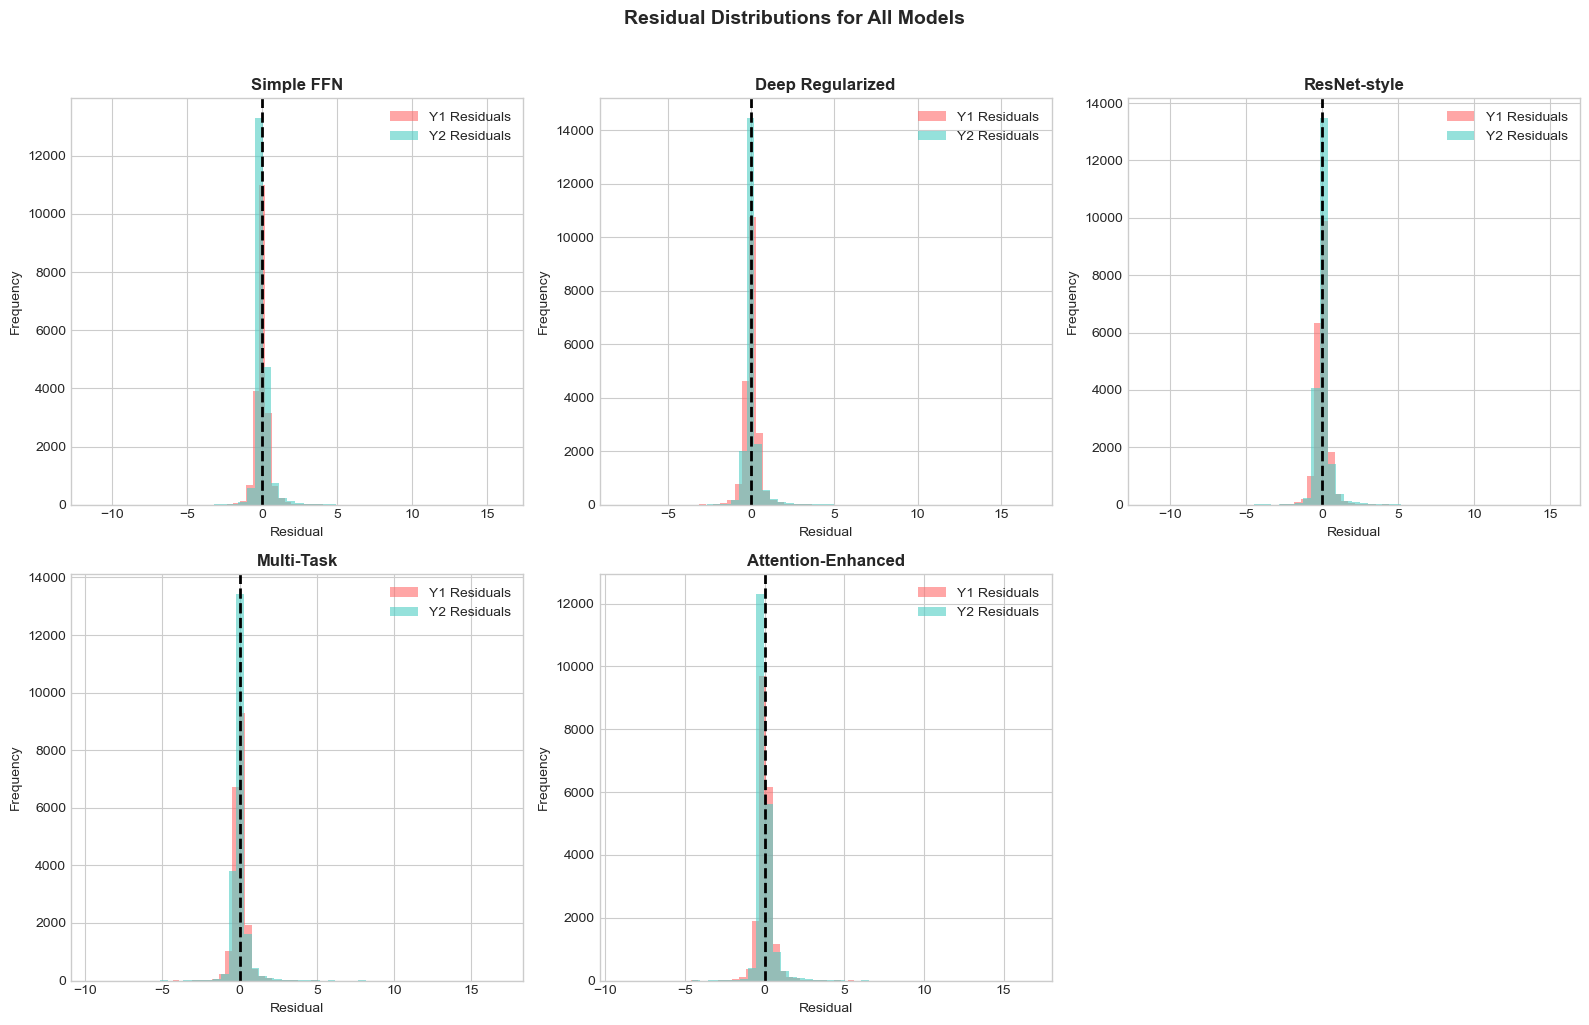

In [87]:
# 5. Residual Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, (name, preds) in enumerate(predictions.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Calculate residuals
    residuals_y1 = y_test[:, 0] - preds[:, 0]
    residuals_y2 = y_test[:, 1] - preds[:, 1]
    
    ax.hist(residuals_y1, bins=50, alpha=0.6, label='Y1 Residuals', color=colors[0])
    ax.hist(residuals_y2, bins=50, alpha=0.6, label='Y2 Residuals', color=colors[1])
    
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')
    ax.legend(loc='upper right')

axes[1, 2].axis('off')

plt.suptitle('Residual Distributions for All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('residual_distributions.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Summary and Conclusions


In [88]:
# Final Summary
print("="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

# Sort by average R2
sorted_results = sorted(results.items(), key=lambda x: x[1]['R2_Avg'], reverse=True)

print("\n🏆 MODEL RANKINGS (by Average R² Score):")
print("-"*50)
for rank, (name, metrics) in enumerate(sorted_results, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{medal} {rank}. {name}")
    print(f"      R² Y1: {metrics['R2_Y1']:.4f}")
    print(f"      R² Y2: {metrics['R2_Y2']:.4f}")
    print(f"      Average R²: {metrics['R2_Avg']:.4f}")
    print()

# Best model
best_model_name = sorted_results[0][0]
best_metrics = sorted_results[0][1]

print("="*80)
print(f"🎯 BEST PERFORMING MODEL: {best_model_name}")
print(f"   Average R² Score: {best_metrics['R2_Avg']:.4f}")
print("="*80)

# Model characteristics summary
print("\n📊 MODEL ARCHITECTURE CHARACTERISTICS:")
print("-"*50)
characteristics = {
    'Simple FFN': 'Basic architecture, fast training, good baseline',
    'Deep Regularized': 'Deep layers with BatchNorm & Dropout for regularization',
    'ResNet-style': 'Skip connections for better gradient flow',
    'Multi-Task': 'Shared representation with task-specific heads',
    'Attention-Enhanced': 'Self-attention for dynamic feature weighting'
}

for name, desc in characteristics.items():
    print(f"• {name}: {desc}")


FINAL MODEL COMPARISON SUMMARY

🏆 MODEL RANKINGS (by Average R² Score):
--------------------------------------------------
🥇 1. ResNet-style
      R² Y1: 0.7587
      R² Y2: 0.6989
      Average R²: 0.7288

🥈 2. Deep Regularized
      R² Y1: 0.7539
      R² Y2: 0.7023
      Average R²: 0.7281

🥉 3. Multi-Task
      R² Y1: 0.7462
      R² Y2: 0.6984
      Average R²: 0.7223

   4. Simple FFN
      R² Y1: 0.7477
      R² Y2: 0.6717
      Average R²: 0.7097

   5. Attention-Enhanced
      R² Y1: 0.7282
      R² Y2: 0.6790
      Average R²: 0.7036

🎯 BEST PERFORMING MODEL: ResNet-style
   Average R² Score: 0.7288

📊 MODEL ARCHITECTURE CHARACTERISTICS:
--------------------------------------------------
• Simple FFN: Basic architecture, fast training, good baseline
• Deep Regularized: Deep layers with BatchNorm & Dropout for regularization
• ResNet-style: Skip connections for better gradient flow
• Multi-Task: Shared representation with task-specific heads
• Attention-Enhanced: Self-attentio

In [82]:
# Save results to JSON
import json

results_to_save = {
    name: {
        'R2_Y1': float(metrics['R2_Y1']),
        'R2_Y2': float(metrics['R2_Y2']),
        'R2_Avg': float(metrics['R2_Avg']),
        'MSE_Y1': float(metrics['MSE_Y1']),
        'MSE_Y2': float(metrics['MSE_Y2']),
        'MAE_Y1': float(metrics['MAE_Y1']),
        'MAE_Y2': float(metrics['MAE_Y2'])
    }
    for name, metrics in results.items()
}

with open('deep_learning_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print("Results saved to 'deep_learning_results.json'")
print("\nAll visualizations saved as PNG files.")


Results saved to 'deep_learning_results.json'

All visualizations saved as PNG files.
